In [29]:
import torch
import numpy as np
import argparse
from utils import dotdict
from activation_dataset import setup_token_data
import wandb
import json
from datetime import datetime
from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt


cfg = dotdict()
# models: "EleutherAI/pythia-6.9b", "usvsnsp/pythia-6.9b-ppo", "lomahony/eleuther-pythia6.9b-hh-sft", "reciprocate/dahoas-gptj-rm-static"
# "EleutherAI/pythia-70m", "lomahony/eleuther-pythia70m-hh-sft"
cfg.model_name="EleutherAI/pythia-70m"
cfg.target_name="BlueSunflower/Pythia-70M-chess"
cfg.layers=[4]
cfg.setting="residual"
# cfg.tensor_name="gpt_neox.layers.{layer}"
cfg.tensor_name="gpt_neox.layers.{layer}" # "gpt_neox.layers.{layer}" (pythia), "transformer.h.{layer}" (rm)
cfg.target_tensor_name="gpt_neox.layers.{layer}"
original_l1_alpha = 2e-3
cfg.l1_alpha=original_l1_alpha
cfg.l1_alphas=[2e-3,]
# cfg.l1_alphas=[0, 1e-5, 1e-4, 2e-4, 4e-4, 8e-4, 1e-3, 2e-3, 4e-3, 8e-3]
cfg.sparsity=None
cfg.num_epochs=10
cfg.model_batch_size=8 * 8
cfg.lr=1e-3
cfg.kl=False
cfg.reconstruction=False
# cfg.dataset_name="NeelNanda/pile-10k"
cfg.dataset_name="Elriggs/openwebtext-100k"
cfg.device="cuda:0"
cfg.ratio = 4
cfg.seed = 0
cfg.max_length = 256
# cfg.device="cpu"

In [27]:
# base_name = "sft"  # base, rm
# capitalized_base_name = "SFT'd" # Base, RM, SFT'd
# target_name = "base"  # sft, ppo
# finetuning_type = "Base"  # SFT'd, RLHF'd

base_name = "base"  # base, rm
capitalized_base_name = "Base" # Base, RM, SFT'd
target_name = "sft"  # sft, ppo
finetuning_type = "SFT'd"  # SFT'd, RLHF'd


In [28]:
tensor_names = [cfg.tensor_name.format(layer=layer) for layer in cfg.layers]
target_tensor_names = [cfg.target_tensor_name.format(layer=layer) for layer in cfg.layers]

In [31]:
# Initialize New transfer autoencoder
# from autoencoders.learned_dict import TiedSAE, UntiedSAE, AnthropicSAE, TransferSAE
from torch import nn

modes = ["scale", "rotation", "bias", "free"]
mode = "free"

checkpoint = 0

# mode_tsae = torch.load(f"trained_models/transfer_{base_name}_{target_name}_70m_{mode}.pt")
mode_tsaes = []
autoTEDs = []
dead_features = []

model_dir = "/root/sparse_coding/trained_models"
for layer in cfg.layers:
    l1_tsaes = []
    l1_autoTEDS = []
    l1_dead_features = []
    for l1_alpha in cfg.l1_alphas:
        mode_tsae = torch.load(f"{model_dir}/transfer_base_chess_70m/transfer_base_chess_70m_{mode}_{layer}_{l1_alpha}.pt")
        mode_tsae.to_device(cfg.device)
        l1_tsaes.append(mode_tsae)
        
        autoTED = torch.load(f"{model_dir}/base_autoTED_70m/base_autoTED_70m_{layer}_{l1_alpha}.pt")
        autoTED.to_device(cfg.device)
        l1_autoTEDS.append(autoTED)
        
        c = torch.load(f"{model_dir}/base_dead_features_70m/base_dead_features_70m_{layer}_{l1_alpha}.pt")
        c.to(cfg.device)
        l1_dead_features.append(c)
        
    mode_tsaes.append(l1_tsaes)
    autoTEDs.append(l1_autoTEDS)
    dead_features.append(l1_dead_features)


In [32]:
# Pick just one to focus on
layer = 4
l1_id = 0 # corresponds to cfg.l1_alphas[l1_id]
autoTED = autoTEDs[layer][l1_id]
mode_tsae = mode_tsaes[layer][l1_id]
dead_feature = dead_features[layer][l1_id]

IndexError: list index out of range

tensor(1446)


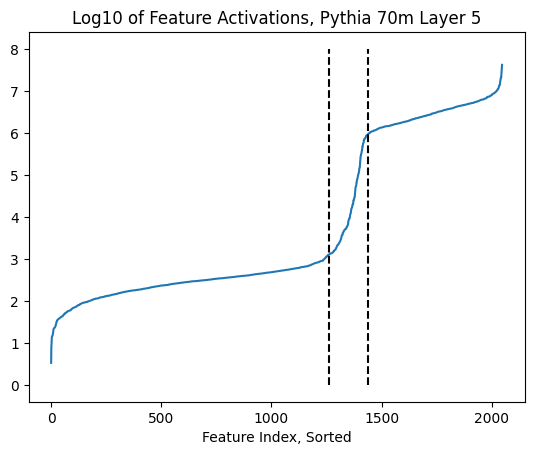

In [33]:
sorted_acts = sorted((dead_feature.numpy().copy()))
print(sum(dead_feature<1e6))

lower_index = 1260 # 800 for 8e-4
upper_index = 1440 # 950 for 8e-4

plt.plot(sorted(list(dead_feature.log10().numpy())))
plt.vlines([lower_index,upper_index],0,8, colors=['black'], linestyles='dashed')
plt.title("Log10 of Feature Activations, Pythia 70m Layer 5")
plt.xlabel("Feature Index, Sorted")
plt.show()

lower_boundary = sorted_acts[lower_index]
upper_boundary = sorted_acts[upper_index]
vip_features = dead_feature > upper_boundary
transition_features = (dead_feature > lower_boundary) * (dead_feature <= upper_boundary)
weak_features = dead_feature <= lower_boundary

In [34]:
autoTED.get_learned_dict().shape

torch.Size([2048, 512])

In [35]:
dead_feature

tensor([2.0611e+02, 2.1852e+02, 1.9808e+06,  ..., 6.2066e+02, 1.6548e+06,
        3.1859e+02])

Text(0.5, 0, 'Log10 Feature Activations')

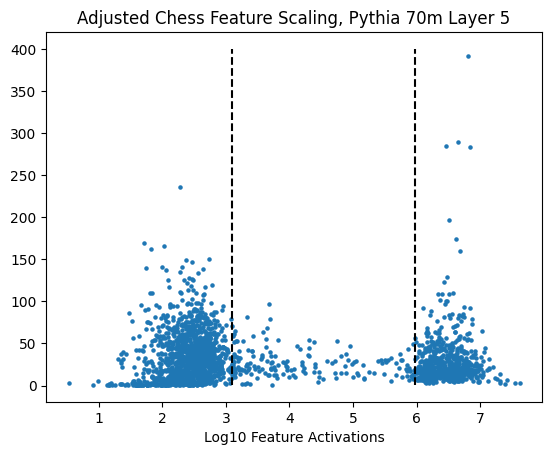

In [39]:
# plt.plot(reference_scales)
# mode_tsae = mode_tsaes[lay][l1]
# autoTED = autoTEDs[lay][l1]
# acts = dead_features[lay][l1]

scales = mode_tsae.get_feature_scales()
reference_scales = autoTED.get_feature_scales()
list_scales = list((scales/reference_scales).abs().detach().cpu().numpy())

plt.scatter(dead_feature.log10(), list_scales, s=5)
plt.vlines([np.log10(lower_boundary),np.log10(upper_boundary)],0.7,400, colors=['black'], linestyles='dashed')
# plt.ylim(0.7,1.9)
plt.title("Adjusted Chess Feature Scaling, Pythia 70m Layer 5") # AutoTED Scaling, Pythia 70m Layer 5
plt.xlabel("Log10 Feature Activations")

Mean scaling: 0.9952687675124142


Text(0.5, 0, 'Strong Features')

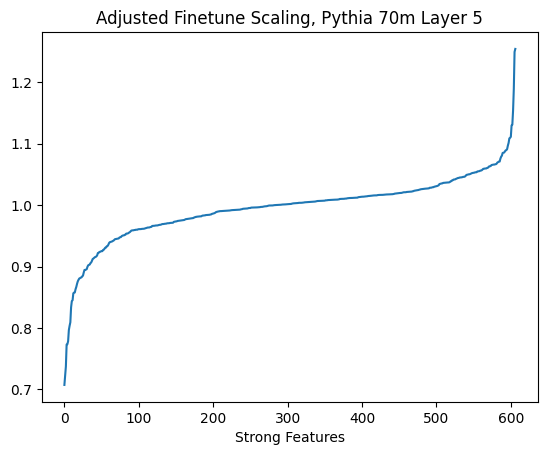

In [17]:
filtering = vip_features # weak_features # transition_features # vip_features
scales = mode_tsae.get_feature_scales()[filtering]
reference_scales = autoTED.get_feature_scales()[filtering]
# feature_vectors = transfer_free.get_learned_dict()[live_features]
list_scales = list((scales/reference_scales).abs().detach().cpu().numpy())
print(f"Mean scaling: {sum(list_scales)/len(list_scales)}")
plt.plot(sorted(list_scales))
plt.title("Adjusted Finetuned Feature Scaling, Pythia 70m Layer 5")
plt.xlabel("Strong Features")
# plt.plot(scales.detach().cpu().numpy())

In [ ]:
plt.plot(sorted(list_scales))
plt.title(f"Feature Scaling from {capitalized_base_name} to {finetuning_type} 70m LLM (Checkpoint {checkpoint})")
plt.xlabel("Feature")
plt.savefig(f"feature_scaling_{base_name}_{target_name}_{mode}_ckpt{checkpoint}_70m")

In [ ]:
dead_features[live_features]

In [ ]:
for lay in range(len(cfg.layers)):
    for l1 in range(len(cfg.l1_alphas)):
        layer = cfg.layers[lay]
        l1_alpha = cfg.l1_alphas[l1]
        
        mode_tsae = mode_tsaes[lay][l1]
        autoTED = autoTEDs[lay][l1]
        acts = dead_features[lay][l1]
        
        scales = mode_tsae.get_feature_scales()
        reference_scales = autoTED.get_feature_scales()
        list_scales = list((scales/reference_scales).abs().detach().cpu().numpy())

        plt.scatter(acts.log10(), list_scales, s=5)
        plt.title(f"Feature Scaling from {capitalized_base_name} to {finetuning_type} 70m LLM vs Activations (Layer {layer}, L1 {l1_alpha})")
        plt.xlabel("Log10 of Total Feature Activations")
        plt.ylabel("Feature Scaling")
        plt.ylim(0,10)
        # plt.savefig(f"feature_scaling_vs_activations_{base_name}_{target_name}_{mode}_ckpt{checkpoint}_70m")

In [ ]:
lay = 3
# l1 = 12
for l1 in range(0,len(cfg.l1_alphas), 3):
    layer = cfg.layers[lay]
    l1_alpha = cfg.l1_alphas[l1]
    print(l1_alpha)

    mode_tsae = mode_tsaes[lay][l1]
    autoTED = autoTEDs[lay][l1]
    acts = dead_features[lay][l1]

    print(sum(acts < 10**6))
    print(sum(acts > 10**6))

    scales = mode_tsae.get_feature_scales()
    reference_scales = autoTED.get_feature_scales()
    list_scales = list((scales/reference_scales).abs().detach().cpu().numpy())
    list_scales = list((reference_scales).abs().detach().cpu().numpy())
    # list_scales = list((scales).abs().detach().cpu().numpy())

    plt.scatter(acts.log10(), list_scales, s=5)
    plt.title(f"AutoTED Scaling from {capitalized_base_name} to {finetuning_type} 70m LLM vs Activations (Layer {layer})")
    plt.xlabel("Log10 of Total Feature Activations")
    plt.ylabel("Feature Scaling")
    plt.ylim(0,6)
    # plt.savefig(f"feature_scaling_vs_activations_{base_name}_{target_name}_{mode}_ckpt{checkpoint}_70m")

In [ ]:
lay = 4
# l1 = 12
for l1 in range(0,len(cfg.l1_alphas), 3):
    layer = cfg.layers[lay]
    l1_alpha = cfg.l1_alphas[l1]

    mode_tsae = mode_tsaes[lay][l1]
    autoTED = autoTEDs[lay][l1]
    acts = dead_features[lay][l1]
    print(sum(acts < 10**4))
    print(sum((acts > 10**4) * (acts < 10**6)))
    print(sum(acts > 10**6))

    scales = mode_tsae.get_feature_scales()
    reference_scales = autoTED.get_feature_scales()
    list_scales = list((scales/reference_scales).abs().detach().cpu().numpy())
    # list_scales = list((reference_scales).abs().detach().cpu().numpy())
    # list_scales = list((scales).abs().detach().cpu().numpy())

    plt.scatter(acts.log10(), list_scales, s=2)
    plt.title(f"Feature Scaling from {capitalized_base_name} to {finetuning_type} 70m LLM vs Activations (Layer {layer})")
    plt.xlabel("Log10 of Total Feature Activations")
    plt.ylabel("Feature Scaling")
    plt.ylim(0,6)
    # plt.savefig(f"feature_scaling_vs_activations_{base_name}_{target_name}_{mode}_ckpt{checkpoint}_70m")

Outputting Most Scaled Features

In [41]:
# most scaled features
lay = 4
l1 = 0
layer = cfg.layers[lay]
l1_alpha = cfg.l1_alphas[l1]
filter = vip_features

print(f"Layer {lay} (0 indexed), l1 {l1_alpha}")

mode_tsae = mode_tsaes[lay][l1]
autoTED = autoTEDs[lay][l1]
acts = dead_features[lay][l1]

large_filter = vip_features

scales = mode_tsae.get_feature_scales()
reference_scales = autoTED.get_feature_scales()
list_scales = ((scales/reference_scales).abs().detach().cpu().numpy())

argsorted_scales = [id for id in np.argsort(list_scales) if filter[id]==True]  # filtered to only include features with large activations

print(f"Top 10 scaled are: {argsorted_scales[-5:][::-1]}")
print(f"Bottom 10 scaled are: {argsorted_scales[:5]}")

Layer 0 (0 indexed), l1 0.002
Top 10 scaled are: [1041, 414, 1639, 1056, 1141]
Bottom 10 scaled are: [334, 676, 1465, 726, 462]


In [ ]:
argsorted_scales[0]

In [ ]:
large_filter[662]

In [ ]:
list_scales[662]